# **ORC**

**Install & Import**

In [1]:
!pip install pytesseract
!apt install tesseract-ocr




tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
import cv2
from PIL import ImageEnhance , Image , ImageFilter
import numpy as np
from scipy.ndimage import interpolation as inter
import os
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

**Config tessdata**

In [3]:
filenames = os.listdir('/usr/share/tesseract-ocr/4.00/tessdata/')
print(filenames)

['eng.traineddata', 'pdf.ttf', 'tessconfigs', 'configs', 'osd.traineddata']


In [4]:
import shutil
src = '/kaggle/input/tesseractocr/Tesseract-OCR/tessdata/tha.traineddata'
dest = '/usr/share/tesseract-ocr/4.00/tessdata/'
shutil.copy(src, dest)

'/usr/share/tesseract-ocr/4.00/tessdata/tha.traineddata'

In [5]:
filenames = os.listdir('/usr/share/tesseract-ocr/4.00/tessdata/')
print(filenames)

['eng.traineddata', 'pdf.ttf', 'tessconfigs', 'configs', 'osd.traineddata', 'tha.traineddata']


In [6]:
#skew function
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

# **Main ORC**

In [7]:
src = '/kaggle/input/nithan-chadok-hybrid-ocr-ner/images/images/'
kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0,0,0]
])

In [8]:
len(os.listdir(src))

4612

In [9]:
text_dict = []

for i in range(len(os.listdir(src))):
    
    image = cv2.imread(f'{src}{i:05d}.jpg')

    grayinput = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binaryImage = cv2.threshold(grayinput, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernelSize = (5, 5)
    opIterations = 2
    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    dilateImage = cv2.morphologyEx(
        binaryImage,
        cv2.MORPH_DILATE,
        morphKernel,
        None,
        None,
        opIterations,
        cv2.BORDER_REFLECT101
    )
    #set contour
    contours, _ = cv2.findContours(dilateImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #creat bounding box
    bboxs = []
    for contour in contours:
      x,y,w,h = cv2.boundingRect(contour)
      bboxs.append((x,y,w,h))

    #sort bounding box
    bboxs = sorted(bboxs, key=lambda x: x[1])

    #detection the bounding box
    draw_img = image.copy()
    for i,(x,y,w,h) in enumerate(bboxs):
        cv2.rectangle(image, (x,y), (x+w , y+h), (0, 255, 0) , 2)
        image_kub = cv2.rectangle(image, (x,y), (x+w , y+h), (0, 255, 0) , 2)

    #crop image for ORC
    cropped_images = []
    for i, (x, y, w, h) in enumerate(bboxs):
        cropped_img = image[y:y+h, x:x+w]  # use the bounding box for crop image
        cropped_images.append(cropped_img)

    #image_to_string loop
    for img in cropped_images:
        # angle, correcteds = correct_skew(img)
        custom_config = r'--oem 3 --psm 6 -l tha'
        predict = pytesseract.image_to_string(img, config=custom_config).replace(' ','').replace('\n',' ').replace('\x0c','').replace("'",'').replace('''"''','')
        predict = predict.replace(' ','').replace('|','').replace('(','').replace(')','').replace('[','').replace(']',']').replace(',','')
        if predict == '':
          predict = '_'
        text_dict.append(predict) #all text append in text_dict


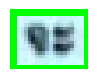

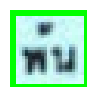

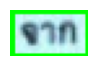

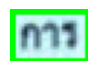

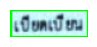

In [10]:
# test visualize
for image in cropped_images[0:5]:
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [11]:
text_dict[0:30]

['ใน',
 'สมัย',
 'หนึ่ง',
 '_',
 '_',
 'ประทับ',
 'จยุ',
 'วัด',
 'เขตวัน',
 '_',
 'เมือง',
 'สาวัตถี',
 'ธง',
 'ปรารภ',
 'พระ',
 '_',
 'นุ้',
 'เบ',
 'หลอกลวจ',
 'ผูอู่น',
 '_',
 'เฟี',
 'ตรัส',
 '_',
 'ฉิทาน',
 'นา',
 'สาธก',
 '_',
 'ว่า',
 '_']

In [12]:
len(text_dict)

64568

In [13]:
check = pd.read_csv('/kaggle/input/nithan-chadok-hybrid-ocr-ner/sample_submission.csv')

In [14]:
len(check)

64568

**result to csv**

In [15]:
#text_dict to csv
final_result = pd.DataFrame(text_dict)

In [16]:
#final_text this is text_dict name
final_result.to_csv('/kaggle/working/final_text.csv',index=False)

# **NER**

# **Import & Installs**

In [17]:
import numpy as np
import pandas as pd
import os

In [18]:
!pip install -q simpletransformers

# **Set data**

In [19]:
import json
from datasets import load_dataset

In [20]:
lst20 = load_dataset("lst20", data_dir="/kaggle/input/lst20corpus/LST20_Corpus")
lst20

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset lst20 downloaded and prepared to /root/.cache/huggingface/datasets/lst20/default-002ce8216dffa51f/0.0.0/e1b2a921fb011578ab43ddbbf789f3c500d62cb2df8ae4ed4b60bae8e4c0d3ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 63310
    })
    validation: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5620
    })
    test: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5250
    })
})

In [21]:
train_df = pd.DataFrame(lst20['train'])
validation_df = pd.DataFrame(lst20['validation'])
train_df.head(5)

,id,fname,tokens,pos_tags,ner_tags,clause_tags
0,0,T00126.txt,"[สุรยุทธ์, ยัน, ปฏิเสธ, ลงนาม, _, MOU, _, กับ,...","[0, 1, 1, 1, 2, 0, 2, 4, 0, 12, 1, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]"
1,1,T00126.txt,"[1, _, กันยายน, _, 2550, _, 12:21, _, น.]","[8, 2, 0, 2, 8, 2, 8, 2, 10]","[3, 13, 13, 13, 23, 0, 3, 13, 23]","[1, 2, 2, 2, 2, 2, 2, 2, 3]"
2,2,T00126.txt,"[นายก, ฯ, _, ย้ำ, ไม่, ลงนาม, ใน, _, MOU, _, ร...","[0, 2, 2, 1, 12, 1, 4, 2, 0, 2, 4, 0, 3, 5, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, ..."
3,3,T00126.txt,"[ยัน, ไทย, ไม่, ได้, ล้มเหลว, ถึง, ขั้น, นั้น,...","[1, 0, 12, 5, 1, 1, 0, 9, 1, 7, 1, 0, 9, 12, 1...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,4,T00126.txt,"[พร้อม, หนุน, กกต., จัด, เลือกตั้ง, ให้, บริสุ...","[3, 1, 0, 1, 1, 3, 1, 1]","[0, 0, 7, 0, 0, 0, 0, 0]","[1, 2, 2, 2, 3, 1, 2, 3]"


In [22]:
df_filter = ['id', 'tokens', 'ner_tags']
train_df = train_df[df_filter]
validation_df = validation_df[df_filter]
train_df.head(5)

,id,tokens,ner_tags
0,0,"[สุรยุทธ์, ยัน, ปฏิเสธ, ลงนาม, _, MOU, _, กับ,...","[8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]"
1,1,"[1, _, กันยายน, _, 2550, _, 12:21, _, น.]","[3, 13, 13, 13, 23, 0, 3, 13, 23]"
2,2,"[นายก, ฯ, _, ย้ำ, ไม่, ลงนาม, ใน, _, MOU, _, ร...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, ..."
3,3,"[ยัน, ไทย, ไม่, ได้, ล้มเหลว, ถึง, ขั้น, นั้น,...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[พร้อม, หนุน, กกต., จัด, เลือกตั้ง, ให้, บริสุ...","[0, 0, 7, 0, 0, 0, 0, 0]"


In [23]:
NER = [
       "O",
        "B_BRN",        "B_DES",        "B_DTM",        "B_LOC",        "B_MEA",        "B_NUM",        "B_ORG",        "B_PER",        "B_TRM",        "B_TTL",
       "I_BRN",        "I_DES",        "I_DTM",        "I_LOC",        "I_MEA",        "I_NUM",        "I_ORG",        "I_PER",        "I_TRM",        "I_TTL",
        "E_BRN",        "E_DES",        "E_DTM",        "E_LOC",        "E_MEA",        "E_NUM",        "E_ORG",        "E_PER",        "E_TRM",        "E_TTL"]
print(NER)

['O', 'B_BRN', 'B_DES', 'B_DTM', 'B_LOC', 'B_MEA', 'B_NUM', 'B_ORG', 'B_PER', 'B_TRM', 'B_TTL', 'I_BRN', 'I_DES', 'I_DTM', 'I_LOC', 'I_MEA', 'I_NUM', 'I_ORG', 'I_PER', 'I_TRM', 'I_TTL', 'E_BRN', 'E_DES', 'E_DTM', 'E_LOC', 'E_MEA', 'E_NUM', 'E_ORG', 'E_PER', 'E_TRM', 'E_TTL']


**convert data to dataframe**

In [24]:
def convert_data_to_df(df):
  data_df = pd.DataFrame()
  sentence_id = []
  words = []
  labels = []

  for sentence in range(len(df)):
    for token in range(len(df['tokens'][sentence])):
      sentence_id.append(sentence)
      words.append(df['tokens'][sentence][token])
      labels.append(NER[df['ner_tags'][sentence][token]]) #Map 0 to "O", 1 to "B_BRN"

  return pd.DataFrame(
      {"sentence_id": sentence_id, "words": words, "labels": labels}
  )

In [25]:
train_data = convert_data_to_df(train_df)
train_data.head(5)

,sentence_id,words,labels
0,0,สุรยุทธ์,B_PER
1,0,ยัน,O
2,0,ปฏิเสธ,O
3,0,ลงนาม,O
4,0,_,O


In [26]:
eval_data = convert_data_to_df(validation_df )
eval_data.head(5)

,sentence_id,words,labels
0,0,สลด,O
1,0,ผัว,O
2,0,เมีย,O
3,0,เฒ่า,O
4,0,ถูก,O


# **Setup NER model and train model**

In [27]:
import logging
from simpletransformers.ner import NERModel, NERArgs
import torch

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

2024-03-10 10:16:12.326146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 10:16:12.326286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 10:16:12.486615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
ner_args = NERArgs()
ner_args.train_batch_size = 128
ner_args.use_multiprocessing = True
ner_args.evaluate_during_training = True
ner_args.eval_batch_size = 256
ner_args.num_train_epochs = 2
ner_args.overwrite_output_dir = True
ner_args.max_seq_length = 81
ner_args.gradient_accumulation_steps = 4

model = NERModel(
     "camembert", # Model Type
     "airesearch/wangchanberta-base-att-spm-uncased",  #Ner Pre-trained Model
     args=ner_args, use_cuda=torch.cuda.is_available(), labels=NER # Local Config
)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/simpletransformers/ner/ner_model.py:433: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn(


In [29]:
torch.cuda.is_available()

True

In [30]:
model.train_model(train_data, eval_data=eval_data)

  0%|          | 0/63310 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_NUM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_DTM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_DTM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.p

Running Epoch 2 of 2:   0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

(246,
 defaultdict(list,
             {'global_step': [123, 246],
              'train_loss': [0.21103638410568237, 0.13146629929542542],
              'eval_loss': [0.20064156807281755, 0.1775867688384923],
              'precision': [0.65881915289366, 0.6893557723228642],
              'recall': [0.7172529507058552, 0.7441564452672992],
              'f1_score': [0.6867953796293732, 0.7157086417005175]}))

In [31]:
result, model_outputs, preds_list = model.eval_model(eval_data)

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

# **Prepare test data (data for predict)**

In [32]:
def cat_string(df):
  text = []
  for i in df['word']:
    text.append(str(i))
  return text

In [33]:
def split_into_sentences(tokens, tokens_per_sentence=30):
    sentences = []
    for i in range(0, len(tokens), tokens_per_sentence):
        sentence = tokens[i:i+tokens_per_sentence]
        sentences.append(sentence)
    return sentences

In [34]:
def_test = pd.read_csv('/kaggle/working/final_text.csv')

In [35]:
def_test.rename(columns={'0': 'word'}, inplace=True)

In [36]:
def_test

,word
0,ใน
1,สมัย
2,หนึ่ง
3,_
4,_
...,...
64563,ไค
64564,เพัน
64565,_
64566,นาง


In [37]:
def_test = cat_string(def_test)
my_token = split_into_sentences(def_test)

In [38]:
my_token[0][0:10]

['ใน', 'สมัย', 'หนึ่ง', '_', '_', 'ประทับ', 'จยุ', 'วัด', 'เขตวัน', '_']

# **Predict and Fillter final answer**

In [39]:
predictions, raw_outputs = model.predict(my_token, False)

  0%|          | 0/2153 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

In [40]:
predictions[0][0:10]

[{'ใน': 'O'},
 {'สมัย': 'O'},
 {'หนึ่ง': 'O'},
 {'_': 'O'},
 {'_': 'O'},
 {'ประทับ': 'O'},
 {'จยุ': 'O'},
 {'วัด': 'B_LOC'},
 {'เขตวัน': 'E_LOC'},
 {'_': 'O'}]

In [41]:
final_test_df = []
for i in range(len(predictions)):
  for j in range(len(predictions[i])):
    data = predictions[i][j]
    value = data.values()
    final_test_df += value

In [42]:
print(final_test_df[0:20])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'E_LOC', 'O', 'B_LOC', 'E_LOC', 'O', 'O', 'O', 'O', 'B_PER', 'O', 'O', 'O']


In [43]:
ner_list = pd.read_csv("/kaggle/input/nithan-chadok-hybrid-ocr-ner/tag_list.csv")
ner_list.head()

,tag,class
0,O,0
1,B_ORG,1
2,B_PER,2
3,B_LOC,3
4,B_MEA,4


In [44]:
Final_NER = []
count = 0
for tags in final_test_df:
  count = 0
  for i in ner_list["tag"]:
    if tags == i:
      Final_NER.append(str(ner_list["class"][count]))
    count += 1
print(Final_NER[0:10])

['0', '0', '0', '0', '0', '0', '0', '3', '12', '0']


In [45]:
final_result = pd.DataFrame(Final_NER)
final_result

,0
0,0
1,0
2,0
3,0
4,0
...,...
64545,2
64546,0
64547,0
64548,0


# **Submission**

In [46]:
submisstion_df = pd.read_csv('/kaggle/input/nithan-chadok-hybrid-ocr-ner/sample_submission.csv')
submisstion_df

,Id,pred
0,0,0.0
1,1,0.0
2,2,0.0
3,3,NaN
4,4,NaN
...,...,...
64563,64563,NaN
64564,64564,NaN
64565,64565,NaN
64566,64566,NaN


In [47]:
submisstion_df['pred'] = final_result
submisstion_df.head(15)

,Id,pred
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,3
8,8,12
9,9,0


In [48]:
submisstion_df[['Id', 'pred']].to_csv('/kaggle/working/submissionkub.csv', index = False)

In [49]:
submisstion_df.head(10)

,Id,pred
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,3
8,8,12
9,9,0
